In [1]:
# !pip install lightgbm

In [12]:
# !pip install unzip

# Teams will be responsible for a 12-minute live presentation that outlines the story of their competition journey. Please include:
### •	Screenshot of your best ranking on the competition website.
   #### o	Note: you will not be graded on the actual performance/ranking in the competition (although I wish you the very best                               of luck)
### •	In your slides, be clear about distinguishing between a model’s cross-validation score (CV score) vs. its                    leaderboard score (LB score).
### •	10%: What cleaning and preprocessing steps did you try? Which worked, and which didn’t?
### •	10%: What feature engineering and selection steps did you try? Which worked, and which didn’t?
### •	10%: Which ML algorithms did you try? Did you try at least one non-tree based algorithm? How well did ### ###      each work? Did you evaluation them using cross validation? How did each model’s CV score compare with    ###      its LB score?
### •	10% What hyperparameter tuning procedure/algorithm did you try? What range of values did you consider? ###      How much did they help performance? What were the final/best values?
### •	10%: What else did you try? Any particular insights or “Eureka!” moments?
### •	10%: Describe your best model/submission in more detail, such as:
   #### o	Describe/quantify the model’s performance using confusion matrices and the associated metrics. 
   #### o	If possible, describe the drivers (i.e., feature importances) of your model’s performance. What did your model “learn?”
   #### o	Show at least three training instances that your model predicted correctly, and at least three training instances that your best model predicted incorrectly. Can you draw any insights from this?
### •	10%: Next steps. Description of what you would try if you had more time/budget. Specify what you would ###     need (in terms of data, compute power, algorithms, etc.) to improve the model’s performance if you had     
###     more time and money. Be as specific as possible.
### •	10% Lessons learned. Inclusion of concise and helpful lessons learned during the project.
### •	20% Clarity of presentation. Overall clarity/understandability of the presentation, including slide design and ###     oral delivery. Ability to answer questions during the Q&A portion of the presentation



In [9]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib','inline')
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier #p140
from sklearn.neighbors import KNeighborsClassifier #p196
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb

sns.set(style = 'white', context = 'notebook', palette = 'deep')

In [10]:
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items

import sys

sys.path.append("./")

In [11]:
client_train = pd.read_csv("client_train.csv")
invoice_train = pd.read_csv("invoice_train.csv")
client_test = pd.read_csv("client_test.csv")
invoice_test = pd.read_csv("invoice_test.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

In [12]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)

(135493, 6) (4476749, 16) (58069, 5) (1939730, 16)


In [13]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [14]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [15]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [16]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [17]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [18]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [19]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [20]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [21]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [22]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

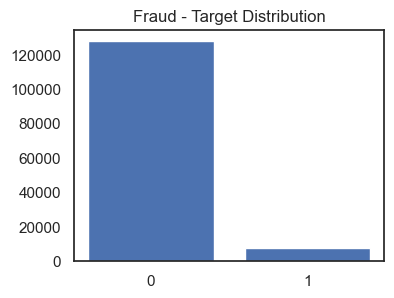

In [23]:
#Visualize fraudulent activities
plt.figure(figsize=(4, 3))
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

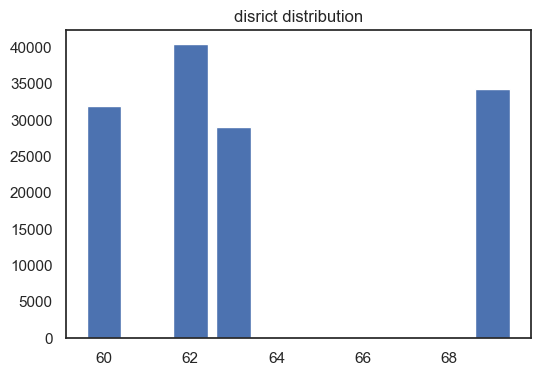

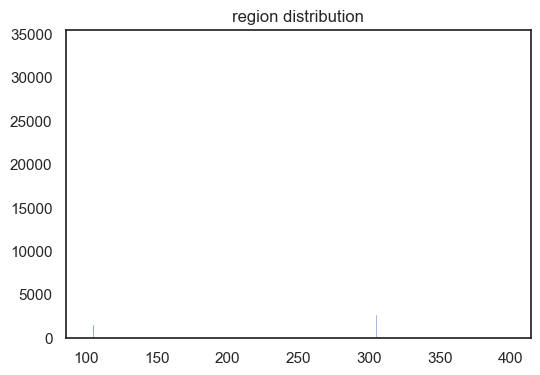

In [24]:
#Visualize client distribution across districts and regions
smaller_size = (6,4)
for col in ['disrict','region']:
    plt.figure(figsize=smaller_size)
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()


# Feature Engineering

In [25]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [26]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [27]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [28]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [29]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [30]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [31]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [32]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [33]:
train.shape, test.shape

((135493, 11), (58069, 10))

In [34]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [35]:
train.head()

,disrict,client_catg,region,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,11,101,0.0,35,352.400000,10.571429,0.000000,0.000000
1,69,11,107,0.0,37,557.540541,0.000000,0.000000,0.000000
2,62,11,301,0.0,18,798.611111,37.888889,0.000000,0.000000
3,69,11,105,0.0,20,1.200000,0.000000,0.000000,0.000000
4,62,11,303,0.0,14,663.714286,104.857143,117.357143,36.714286


# Modelling

## Train LGBM Classifier

In [28]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [29]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: num_iterationss
[LightGBM] [Warning] Unknown parameter: num_iterationss
[LightGBM] [Info] Number of positive: 7566, number of negative: 127927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 135493, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055841 -> initscore=-2.827795
[LightGBM] [Info] Start training from score -2.827795


LGBMClassifier(num_iterationss=500)

In [30]:
x_train.disrict.unique()

array([60, 69, 62, 63])

## Make Predictions on test set

In [31]:
test.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

In [32]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

[LightGBM] [Warning] Unknown parameter: num_iterationss


,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [33]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [34]:
# submission.to_csv('./submission.csv', index=False)

# Daphne's Training

- check 863 imblance data clf = LogisticRegression(class_weight="balanced")- is creating a logistic regression classifier instance with class weights balanced according to the distribution of classes in the training data. This is useful when you have imbalanced classes, and you want the model to be more sensitive to the minority class.
- check Stetve notebook imblance data https://github.com/stepthom/869_course/tree/main/imbalance
- check bns code python server for data traonsform and Team Assignment - Template-1109 for scaler and log transfer
- maybe remove region because it is corrleated to disrict
- maybe remove client_catg  because iv is very low 
- Future Importance

In [36]:
discrete_columns = ['disrict','client_catg', 'region']
continuous_columns = ['1transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean',
'consommation_level_3_mean','consommation_level_4_mean']
total_columns = discrete_columns + continuous_columns


In [37]:
test.head()

,disrict,client_catg,region,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,62,11,307,37,488.135135,3.243243,0.000000,0.000000
1,69,11,103,22,1091.409091,843.136364,182.318182,586.318182
2,62,11,310,74,554.040541,37.364865,15.743243,0.162162
3,60,11,101,40,244.350000,0.000000,0.000000,0.000000
4,62,11,301,53,568.188679,145.056604,33.679245,0.000000


In [38]:
dummy_district_train = pd.get_dummies(train['disrict'],prefix='district')
dummy_client_cat_train = pd.get_dummies(train['client_catg'],prefix='client_catg')
dummy_region_train = pd.get_dummies(train['region'],prefix='region')


dummy_district_test = pd.get_dummies(test['disrict'],prefix='district')
dummy_client_cat_test = pd.get_dummies(test['client_catg'],prefix='client_catg')
dummy_region_test = pd.get_dummies(test['region'],prefix='region')



In [39]:
continuous_columns = ['1transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean',
'consommation_level_3_mean','consommation_level_4_mean']
train_continuous = train[continuous_columns]
train_data_new = pd.concat([dummy_district_train,dummy_client_cat_train,dummy_region_train,train_continuous,train['target']],axis=1)

In [40]:

test_continuous = test[continuous_columns]
test_data_new = pd.concat([dummy_district_test,dummy_client_cat_test,dummy_region_test,test_continuous],axis=1)

In [41]:
train_data_new.head()

,district_60,district_62,district_63,district_69,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,region_106,region_107,region_199,region_206,region_301,region_302,region_303,region_304,region_305,region_306,region_307,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,target
0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,352.400000,10.571429,0.000000,0.000000,0.0
1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,557.540541,0.000000,0.000000,0.000000,0.0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,798.611111,37.888889,0.000000,0.000000,0.0
3,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,1.200000,0.000000,0.000000,0.000000,0.0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,663.714286,104.857143,117.357143,36.714286,0.0


In [42]:
test_data_new.head()

,district_60,district_62,district_63,district_69,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,region_106,region_107,region_206,region_301,region_302,region_303,region_304,region_305,region_306,region_307,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,37,488.135135,3.243243,0.000000,0.000000
1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1091.409091,843.136364,182.318182,586.318182
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,74,554.040541,37.364865,15.743243,0.162162
3,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,244.350000,0.000000,0.000000,0.000000
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,568.188679,145.056604,33.679245,0.000000


In [43]:
x_train = train_data_new.drop(columns=['target'])
y_train = train_data_new['target']

In [44]:
dt_fit = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, random_state =42)

In [45]:
dt_fit.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [46]:
print ("\nDecision Tree - Train Confusion Matrix\n\n", pd.crosstab(y_train, dt_fit.predict(x_train),rownames = ["Actual"],colnames = ['Predicted']))


Decision Tree - Train Confusion Matrix

 Predicted     0.0  1.0
Actual                
0.0        127926    1
1.0          7564    2


In [47]:
print ("\nDecision Tree - Train accuracy\n\n" , round(accuracy_score(y_train, dt_fit.predict(x_train)),3))


Decision Tree - Train accuracy

 0.944


In [48]:
print ("\nDecision Tree - Train Classificatin Report \n", classification_report(y_train,dt_fit.predict(x_train)))


Decision Tree - Train Classificatin Report 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    127927
         1.0       0.67      0.00      0.00      7566

    accuracy                           0.94    135493
   macro avg       0.81      0.50      0.49    135493
weighted avg       0.93      0.94      0.92    135493



In [49]:
# # Print feature names
print("Feature names during training:", x_train.columns)
print("Feature names in test data:", test_data_new.columns)

Feature names during training: Index(['district_60', 'district_62', 'district_63', 'district_69',
       'client_catg_11', 'client_catg_12', 'client_catg_51', 'region_101',
       'region_103', 'region_104', 'region_105', 'region_106', 'region_107',
       'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
       'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
       'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
       'region_371', 'region_372', 'region_379', 'region_399',
       '1transactions_count', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean'],
      dtype='object')
Feature names in test data: Index(['district_60', 'district_62', 'district_63', 'district_69',
       'client_catg_11', 'client_catg_12', 'client_catg_51', 'region_101',
       'region_103', 'region_104', 'region_105', 'region_106', 'region_107',
       'region_206', 'regi

In [50]:
test_data_new['region_199'] = 0  # You can use any default value
x_test = test_data_new[x_train.columns]
x_test.head()

,district_60,district_62,district_63,district_69,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,region_106,region_107,region_199,region_206,region_301,region_302,region_303,region_304,region_305,region_306,region_307,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,37,488.135135,3.243243,0.000000,0.000000
1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1091.409091,843.136364,182.318182,586.318182
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,74,554.040541,37.364865,15.743243,0.162162
3,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,244.350000,0.000000,0.000000,0.000000
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,568.188679,145.056604,33.679245,0.000000


In [52]:
preds_dt = dt_fit.predict(x_test)
preds_dt = pd.DataFrame(preds_dt, columns=['target'])
preds_dt.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [54]:
# print("y_test shape:", y_test.shape)
# print("Predicted values shape:", dt_fit.predict(x_test).shape)

y_test shape: (58069, 1)
Predicted values shape: (58069,)


In [53]:
y_test_1d = preds_dt.values.ravel()

In [54]:
from tabulate import tabulate
# Now, you can use pd.crosstab()
confusion_matrix = pd.crosstab(y_test_1d, dt_fit.predict(x_test), rownames=["Actual"], colnames=["Predicted"])

# Print the formatted confusion matrix
print("\n\nDecision Tree - Test Confusion Matrix\n")
print(tabulate(confusion_matrix, headers='keys', tablefmt='fancy_grid'))



Decision Tree - Test Confusion Matrix

╒══════════╤═══════╤═══════╕
│   Actual │   0.0 │   1.0 │
╞══════════╪═══════╪═══════╡
│        0 │ 58067 │     0 │
├──────────┼───────┼───────┤
│        1 │     0 │     2 │
╘══════════╧═══════╧═══════╛


In [55]:
# print ("\n\nDecision Tree - Test Confusion Matrix\n\n",pd.crosstab(y_test_1d, dt_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))
print ("\nDecision Tree - Test accuracy",round(accuracy_score(preds_dt,dt_fit.predict(x_test)),3))
print ("\nDecision Tree - Test Classification Report\n",classification_report( preds_dt, dt_fit.predict(x_test)))


Decision Tree - Test accuracy 1.0

Decision Tree - Test Classification Report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     58067
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00     58069
   macro avg       1.00      1.00      1.00     58069
weighted avg       1.00      1.00      1.00     58069



In [64]:
y_pred_proba = dt_fit.predict_proba(x_test)[:, 1]

# Assuming y_test is a DataFrame with a single column
fpr, tpr, thresholds = roc_curve(preds_dt, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a DataFrame to store AUC scores
auc_df = pd.DataFrame({'Model': ['Decision Tree'], 'AUC': [roc_auc]})

# Print or display the AUC DataFrame
auc_df.head()

,Model,AUC
0,Decision Tree,1.0


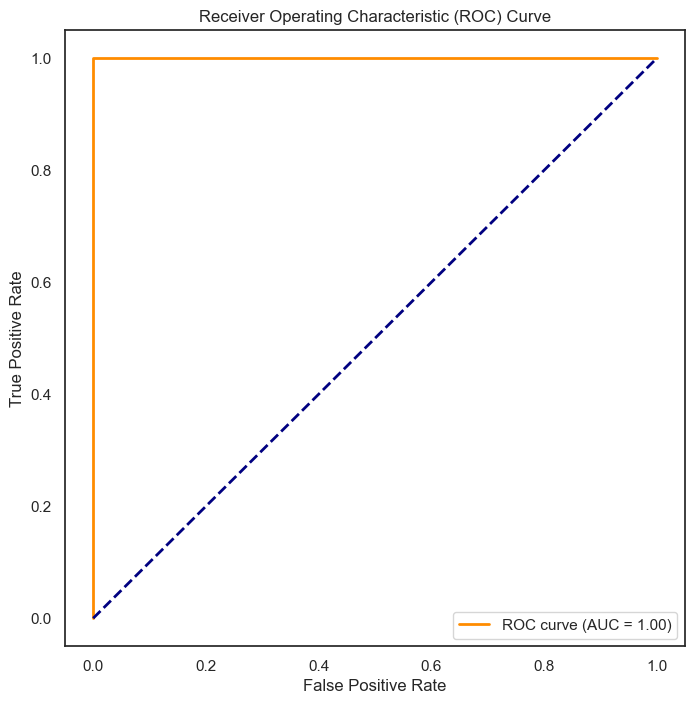

In [56]:
# Assuming y_test is a DataFrame with a single column

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_pred_proba = dt_fit.predict_proba(x_test)[:, 1]

# Assuming y_test is a DataFrame with a single column
fpr, tpr, thresholds = roc_curve(preds_dt, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [58]:
submission_dt = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds_dt['target']
    }
)

submission_dt.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [59]:
submission_dt.to_csv('./submission_dt.csv', index=False)

In [72]:
# auc_df = pd.DataFrame(columns=['sub_client_id', 'AUC'])

# # Calculate AUC for each client
# for client_id in sub_client_id:
#     client_mask = (sub_client_id == client_id)
    
#     # Extract true labels and predicted probabilities for the current client
#     y_true_client = preds_dt[client_mask]
#     y_pred_proba_client = y_pred_proba[client_mask]
    
#     # Calculate ROC curve and AUC
#     fpr, tpr, _ = roc_curve(y_true_client, y_pred_proba_client)
#     auc_score = auc(fpr, tpr)
    
#     # Append results to the DataFrame
#     auc_df = auc_df.append({'sub_client_id': client_id, 'AUC': auc_score}, ignore_index=True)

# # Print or display the AUC DataFrame
# auc_df.head()